# Classification in Asteroseismology

# Introduction

There are seven main types of stars in the world of astronomy: In order of decreasing temperature, there are stars O, B, A, F, G, K, and M. This is known as the Morgan–Keenan (MK) system (Ridpath, 2012). For this project, we want to solve the question, “Given a certain temperature and absolute magnitude, what type of star do we have?” This is a classification problem, specifically for determining star type, whether a star is a Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence, Super Giant or Hyper Giant according to the temperature and the absolute magnitude. The Encyclopædia Britannica states that absolute magnitude (M) is a measure of the luminosity of a celestial object: it measures the star’s luminosity at a distance of 32.6 light years, ensuring the measurements are all standard and relative to each other. The energy inside a star increases from Red Dwarf to Hyper Giants. Therefore, each type of star has its own specific properties including a temperature range and a range of absolute magnitude. We want to look at how we can use these two star properties to predict what type a star could be. We will be using a dataset from Kaggle called “Star Type Classification / NASA”. There are 240 observations in the dataset, 4 quantitative variables (Temperature, Luminosity, Solar Radius, Absolute Magnitude) and 3 qualitative variables (Color, Spectral Class, Type), we will choose temperature and absolute magnitude as our variables to predict star type.

# Methods and Results

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In our project, we are using a classification model to predict the type of the stars (`Type`) based on two predictors: Temperature(K) (`Temperature`) and Absolute Magnitude (`A_M`). In our dataset, the type of stars is represented by 0, 1, 2, 3, 4, 5, where 0 = Red Dwarf, 1 = Brown Dwarf, 2 = White Dwarf, 3 = Main Sequence, 4 = Super Giants, 5 = Hyper Giants.

First, we need to load data from the original source on the web using `read_csv` function, and we name the dataset `Stars`. We can have a look of our dataset using `head` function.

In [2]:
Stars <- read_csv("https://raw.githubusercontent.com/yclllll/stars-set/main/Stars.csv")
head(Stars)

Parsed with column specification:
cols(
  Temperature = col_double(),
  L = col_double(),
  R = col_double(),
  A_M = col_double(),
  Color = col_character(),
  Spectral_Class = col_character(),
  Type = col_double()
)



Temperature,L,R,A_M,Color,Spectral_Class,Type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
3068,0.002400,0.1700,16.12,Red,M,0
3042,0.000500,0.1542,16.60,Red,M,0
2600,0.000300,0.1020,18.70,Red,M,0
2800,0.000200,0.1600,16.65,Red,M,0
1939,0.000138,0.1030,20.06,Red,M,0
2840,0.000650,0.1100,16.98,Red,M,0


*Table 1.1. Loaded original data set*

As we can see, we have seven columns in the dataset, but we only need three of them, which are `Temperature`, `A_M`, and `Type`. Thus, we need to wrangle and clean the data from it's original (downloaded) format to the format necessary for the planned analysis. To clean our data, we will use `select` function to choose the columns we need and make the data into a new data called `stars`, and then we will convert `Type` from double to factor using `as_factor` function since `Type` is the target that we will predict in this project. We can have a look of our new data using `head` function again. 

In [5]:
stars <- Stars %>%
select(Temperature, A_M, Type) %>%
mutate(Type = as_factor(Type))

head(stars)
tail(stars)

Temperature,A_M,Type
<dbl>,<dbl>,<fct>
3068,16.12,0
3042,16.60,0
2600,18.70,0
2800,16.65,0
1939,20.06,0
2840,16.98,0


Temperature,A_M,Type
<dbl>,<dbl>,<fct>
21904,-7.67,5
38940,-9.93,5
30839,-10.63,5
8829,-10.73,5
9235,-11.23,5
37882,-7.80,5


*Table 1.2. Created new data frame with variables that we need*

We want to split `stars` data into training data and testing data using `initial_split` function. We want to use 75% of the data as training data, and we use `prop` to set this. For the `strata` argument, we place the variable we want to classify, `Type`. We call the training set `star_training` and the testing set `star_testing`.

In [6]:
set.seed(1)

star_split <- initial_split(stars, prop = 0.75, strata = Type)
star_training <- training(star_split)
star_testing <- testing(star_split)

head(star_training)
head(star_testing)

Temperature,A_M,Type
<dbl>,<dbl>,<fct>
3042,16.60,0
2600,18.70,0
1939,20.06,0
2840,16.98,0
2637,17.22,0
2600,17.40,0


Temperature,A_M,Type
<dbl>,<dbl>,<fct>
3068,16.12,0
2800,16.65,0
2799,14.79,1
3192,13.53,1
3441,11.18,1
12990,12.23,2


*Table 1.3. The data frame of training set and testing set*

Then, we want to summarize our data. We only use training set here since we are performing preliminary exploratory data analysis. We first use `summary()` function to find the statistics for each column. Then, we want to see the number of observations in each class `Type`. To perform this, we will use `group_by` function to group the data into different types, and then we will use `summarize` and `n()` function to compute the number of observations in each `Type`. We call this column `num_of_obs`. Also, we want to know the means, max and min of the predictor variables we plan to use in our analysis (`Temperature` and `A_M`). We use `mean`, `max`, `min` function to compute the mean temperature (also max and min temperature) and mean absolute magnitude (also max and min absolute magnitude) of each type. We call these six columns `mean_temp`, `max_temp`, `min_temp`, `mean_A_M`, `max_A_M` and `min_A_M`. We name the summary of data `star_summary`. 

In [7]:
set.seed(1)
summary(star_training)

star_summary <- star_training %>%
group_by(Type) %>%
summarize(num__of_obs = n(),
         mean_temp = mean(Temperature),
         max_temp = max(Temperature),
         min_temp = min(Temperature),
         mean_A_M = mean(A_M),
         max_A_M = max(A_M),
         min_A_M = min(A_M))
         

star_summary

  Temperature         A_M          Type  
 Min.   : 1939   Min.   :-11.920   0:30  
 1st Qu.: 3344   1st Qu.: -6.140   1:30  
 Median : 5776   Median :  8.423   2:30  
 Mean   :10643   Mean   :  4.371   3:30  
 3rd Qu.:15377   3rd Qu.: 13.697   4:30  
 Max.   :40000   Max.   : 20.060   5:30  

`summarise()` ungrouping output (override with `.groups` argument)



Type,num__of_obs,mean_temp,max_temp,min_temp,mean_A_M,max_A_M,min_A_M
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,30,2984.267,3531,1939,17.548000,20.060,16.050
1,30,3275.000,3692,2621,12.552833,14.940,10.340
2,30,13620.467,25000,7100,12.686000,14.810,10.550
3,30,16720.633,39000,4526,-0.439800,6.506,-4.700
4,30,15745.633,40000,3008,-6.305733,-5.240,-7.346
5,30,11510.833,38940,3399,-9.814333,-7.580,-11.920


*Table 1.4. The summary of dataset for exploratory data analysis related to the planned analysis*

Then, we will visualize our data `stars` by a scatter plot. We only use training set here since we are performing preliminary exploratory data analysis. We call this plot `star_plot`. We use `ggplot` and `geom_point` to make a scatter plot, and we use `xlab` and `ylab` to label the x-axis and y-axis. We can also label the legend use `labs` function. `ggtitle` gives a title to the plot. `options` function is used to decide the size of the plot and `theme` function is used to determine the font size. 

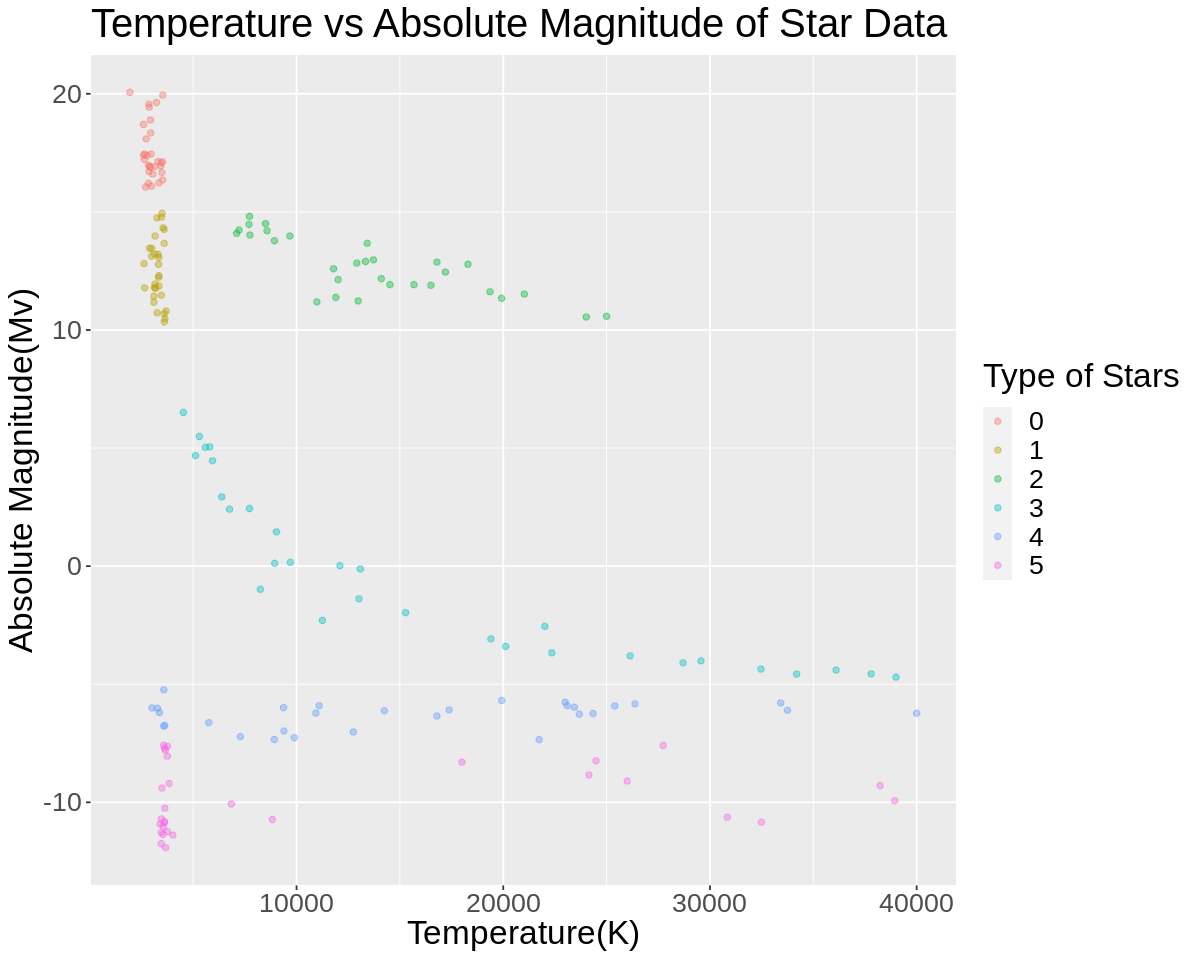

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)

star_plot <- star_training %>%
ggplot(aes(x = Temperature, y = A_M, color = Type)) +
geom_point(alpha = 0.4) +
xlab("Temperature(K)") +
ylab("Absolute Magnitude(Mv)")+
labs(color = "Type of Stars") +
ggtitle("Temperature vs Absolute Magnitude of Star Data") + 
theme(text = element_text(size = 20)) 

star_plot

*Figure 1.1. The visualization of the dataset for exploratory data analysis related to the planned analysis*

Next, we will create the recipe using `recipe` function and `stars_training` data. We also need to standardize our training data since K-nearest neighbors is sensitive to the scale of the predictors. We first pass the target variable `Type` and predictors `Temperature` and `A_M` to the `recipe` function. To scale the predictors, we use `step_scale(all_predictors())` function; to center the predictors, we use `step_center(all_predictors())` function.

In [9]:
set.seed(1)

star_recipe <- recipe(Type ~ Temperature + A_M, data = star_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

star_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

So far, we have split the training and testing datasets as well as preprocessed the data. Then, we will pick the best number of neighbors *K* to build the model. We want to use 5-fold-cross-validation to get a better estimate of accuracy, which will lead to a better choice of the number of neighbours *K* for the overall set of training data. In 5-fold-cross-validation, we split our overall training data into 5 evenly-sized chunks, and then iteratively use 1 chunk as the validation set and combine the remaining 5−1 chunks as the training set. To perform this, we use `vfold_cv` function. In the function, we identify the training set `stars_training`, the number of folds `v` = 5, and the `strata` argument is `Type`.  

In [10]:
set.seed(1)

star_vfold <- vfold_cv(star_training, v = 5, strata = Type)

Using a 5-fold cross-validation, we have established a prediction accuracy for our classifier. Then we want to create a *K*-nearest neighbor model specification. In the specification, we use `tune()` to let each parameter in the model can be adjusted rather than given a specific value. We call the model specification `star_spec`.

In [11]:
set.seed(1)

star_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

star_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Then we create a `workflow()` analysis that combines `star_recipe` and `star_spec` model specification. In the workflow, we will use `tune_grid` function to fit the model for each value in a range of parameter values. For the `resamples` argument, input the `star_vfold` model we created earlier. The `grid` argument specifies that the tuning should try *X* amount of values of the number of neighbors *K* when tuning. In this project, we use number of neighbors from 1 to 50. Finally, we use `collect_metrics()` to  aggregate the mean and standard error. We call this workflow analysis `star_results`.

In [12]:
set.seed(1)

gridvals <- tibble(neighbors = seq(from = 1, to = 50))

star_results <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_spec) %>%
tune_grid(resamples = star_vfold, grid = gridvals) %>%
collect_metrics()

head(star_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9444444,5,0.019641855,Model01
1,roc_auc,hand_till,0.9666667,5,0.011785113,Model01
2,accuracy,multiclass,0.9444444,5,0.019641855,Model02
2,roc_auc,hand_till,0.9869444,5,0.007357179,Model02
3,accuracy,multiclass,0.9166667,5,0.012422600,Model03
3,roc_auc,hand_till,0.9872222,5,0.007868464,Model03


*Table 1.5. Accuracy of each neighbor from 1 to 50*

Now, we can find the best value of the number of neighbors based on `star_results`. We first filter for `accuracy` from the `.metric` column, we call the dataset `accuracies`. Then, we create a line plot using the `accuracies` dataset with `neighbors` on the x-axis and the `mean` on the y-axis. We call the plot `accuracy_vs_k`. `ggtitle` gives a title to the plot.

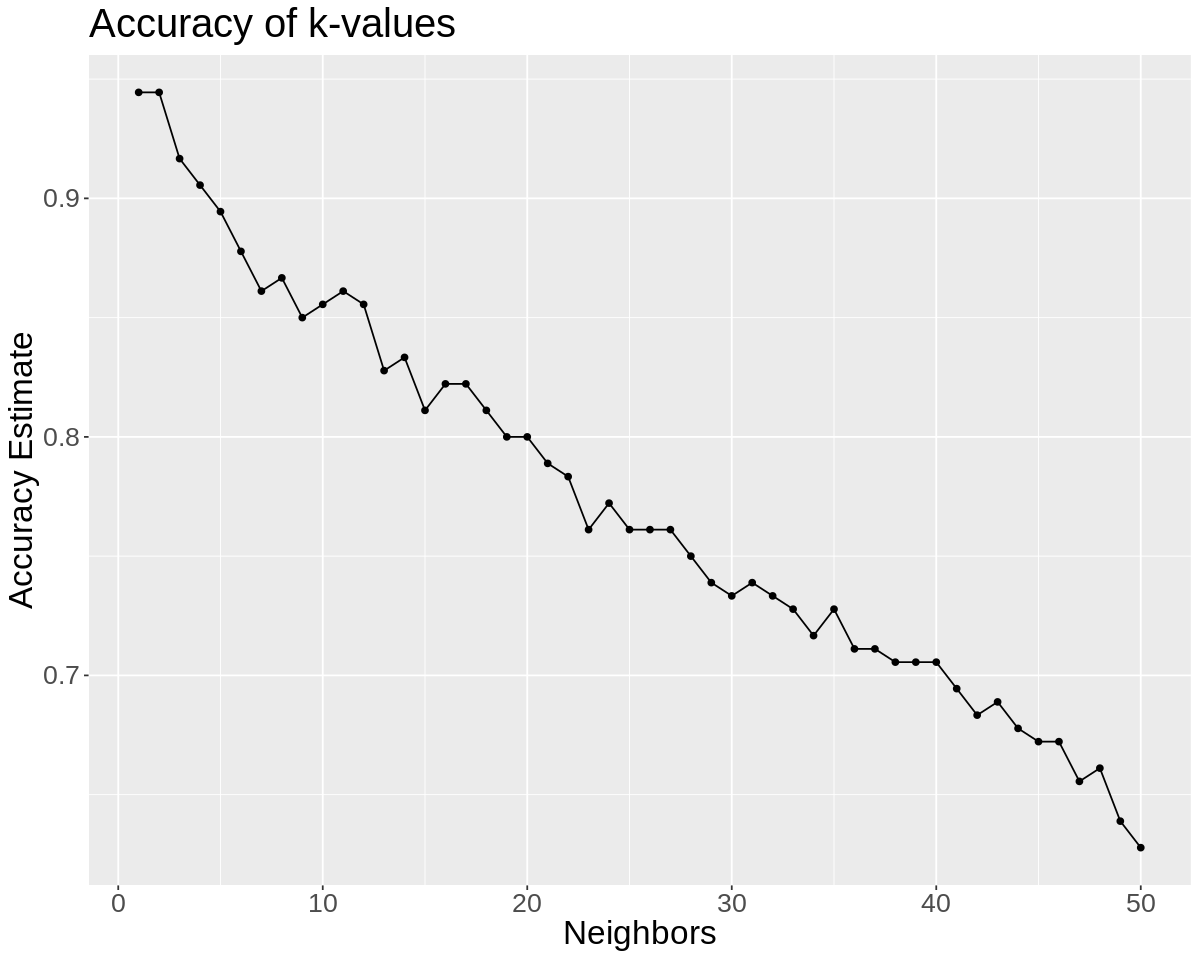

In [13]:
set.seed(1)

accuracies <- star_results %>%
filter(.metric == "accuracy")

accuracy_vs_k <- accuracies %>% 
ggplot(aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Accuracy of k-values") +
theme(text = element_text(size = 20))

accuracy_vs_k

*Figure 1.2. The Visualization of accuracy of k-values*

We can observe from the above plot that *K* = 1, 2 provides the highest accuracy. Therefore, we choose *K* = 2 as the best value of number of neighbors. Now, we will create a new model specification with *K* = 2, we call this new model specification `star_best_spec`. 

In [14]:
star_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
set_engine("kknn") %>%
set_mode("classification")

star_best_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 2
  weight_func = rectangular

Computational engine: kknn 


Then, we train the classifier with the training data `star_training` set using the `workflow` function, so we can bundle together the pre-processing, modeling, and post-processing requests. We name the workflow `star_fit`.

In [15]:
star_fit <- workflow() %>%
add_recipe(star_recipe) %>%
add_model(star_best_spec) %>%
fit(data = star_training)

star_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07777778
Best kernel: rectangular
Best k: 2

Now we are ready to predict the class labels for our testing set. We pass the fitted model and the test dataset `star_testing` to the `predict` function. Then, we use the `bind_cols` function to add the column of predictions to the original test data. We call the predictions `star_predictions`.

In [16]:
star_predictions <- predict(star_fit, star_testing) %>%
bind_cols(star_testing)

head(star_predictions)
tail(star_predictions)

.pred_class,Temperature,A_M,Type
<fct>,<dbl>,<dbl>,<fct>
0,3068,16.12,0
0,2800,16.65,0
1,2799,14.79,1
1,3192,13.53,1
1,3441,11.18,1
2,12990,12.23,2


.pred_class,Temperature,A_M,Type
<fct>,<dbl>,<dbl>,<fct>
3,9320,1.236,3
3,17140,-2.640,3
5,18734,-7.450,4
4,21904,-7.670,5
5,9235,-11.230,5
5,37882,-7.800,5


*Table 1.6. The predictions of testing set using the model we built*

We also want to see our classifier's accuracy. So we use `metrics` function to help us. We input `Type` as the `truth` argument, and `.pred_class` as the `estimate` argument, then we `filter` the `accuracy` row to see the accuracy of our classifier. We call this object `star_test_predictions`.

In [17]:
star_test_predictions <- star_predictions %>%
metrics(truth = Type, estimate = .pred_class) %>%
filter(.metric == "accuracy")

star_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9333333


*Table 1.7. The accuracy of the classifier*

As we can see, our classifier's accuracy is about 93.33%. We also want to look at the confusion matrix for the classifier, which shows us the table of predicted labels and correct labels. We perform this using `conf_mat` function, we need to specify the `truth` and `estimate` argument as we did in `metrics` function. We call this confusion matrix `star_mat`.

In [18]:
star_mat <- star_predictions %>%
conf_mat(truth = Type, estimate = .pred_class)

star_mat

          Truth
Prediction  0  1  2  3  4  5
         0 10  0  0  0  0  0
         1  0 10  0  0  0  0
         2  0  0 10  0  0  0
         3  0  0  0 10  0  0
         4  0  0  0  0  8  2
         5  0  0  0  0  2  8

We will use our classifier, `star_fit`, to attempt to predict three random observations. The first observation is a star with absolute magnitude of 19.45 and a temperature of 3 864 Kelvin. We expect the first star to be of Type 0, Red Dwarf. The second observation is a star with absolute magnitude of -6.00 and a temperature of 48 000 Kelvin. We expect the second observation to be Type 4, a Super Giant. The third observation is a star with absolute magnitude of 9.99 and a temperature of 25 000 Kelvin. We expect the third observation to be Type 2, a White Dwarf.

In [19]:
trial_1 <- tibble(A_M = 19.45, Temperature = 3864)
trial_1_prediction <- predict(star_fit, trial_1)
trial_1_prediction

trial_2 <- tibble(A_M = -6.00, Temperature = 48000)
trial_2_prediction <- predict(star_fit, trial_2)
trial_2_prediction

trial_3 <- tibble(A_M = 9.99, Temperature = 25000)
trial_3_prediction <- predict(star_fit, trial_3)
trial_3_prediction

.pred_class
<fct>
0


.pred_class
<fct>
4


.pred_class
<fct>
2


*Table 1.8. The predictions of the random observations*

# Discussion

As shown in the Methods and Results section, we used the k-nearest neighbor method and created a classification model to determine the star types of our testing data. As a result, the prediction accuracy for the testing data frame is about 93.33% based on our classifier. Our classifier is good for determining an unknown star’s type with a very high accuracy. A confusion matrix was generated to see details of our prediction accuracy. As the table shows, predicting star types 0 to 3 is extremely accurate: no errors were made for predicting Types 0 to 3. However, the accuracy for predicting Types 4 to 5 were slightly less accurate. This table shows us that the minor inaccuracies will likely come from predicting Types 4 to 5.
When the classifier was given random observations (trials 1, 2 and 3), it correctly predicted the expected star types from the given absolute magnitudes and temperatures. Our classifier could help future astronomers quickly and easily identify the type of a star if only temperature and absolute magnitude were given. They would not need to find the values of any other variables, thus saving time and resources. However, this leads us to ask if it would be better to use other variables when creating the classification model, except for temperature and absolute magnitude. Would star types be more accurately classified if we used other variables? Would it be more ideal to have a classifier that incorporates more than two predictor variables (creating a multivariable prediction model)?

# References

Dincer, B. (2021). Star Type Classification / NASA. (Version V1) [Dataset]. Kaggle. https://www.kaggle.com/datasets/brsdincer/star-type-classification

Encyclopædia Britannica, inc. (n.d.). Absolute magnitude. Encyclopædia Britannica. Retrieved April 6, 2022, from https://www.britannica.com/science/absolute-magnitude

Ridpath, I. (2012). Morgan–Keenan classification. In A dictionary of astronomy (2nd ed.). essay, Oxford University Press.